In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50) ## to display more columns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-454'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key_train = 'Project_2/transact_train.txt'
file_key_test = 'Project_2/transact_class.txt'

bucket_object_train = bucket.Object(file_key_train)
file_object_train = bucket_object_train.get()
file_content_stream_train = file_object_train.get('Body')

bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

## Reading the train csv file
train = pd.read_csv(file_content_stream_train, sep = '|', na_values = '?')
train.head(10)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,NaN,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,y,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,y,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2.0,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
5,2,6,5,26.235,0,NaN,NaN,NaN,0,NaN,NaN,NaN,4.0,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
6,2,6,5,71.200,0,NaN,NaN,NaN,0,NaN,NaN,NaN,4.0,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
7,2,6,5,94.469,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
8,3,6,5,181.477,9,29.99,29.99,89.97,1,29.99,29.99,29.99,NaN,NaN,NaN,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,y
9,3,6,5,297.018,11,9.99,29.99,109.95,2,9.99,29.99,39.98,NaN,NaN,NaN,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,y


In [2]:
## Changing labels to numbers
train['order_numb'] = np.where(train['order'] == 'y', 1, 0)
train.head()

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order,order_numb
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,NaN,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,y,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,y,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2.0,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1


In [9]:
train[train['sessionNo'] == 1]

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order,order_numb
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,NaN,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,y,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,y,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,1


In [10]:
train[train['sessionNo'] == 2]

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order,order_numb
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2.0,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1
5,2,6,5,26.235,0,NaN,NaN,NaN,0,NaN,NaN,NaN,4.0,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1
6,2,6,5,71.200,0,NaN,NaN,NaN,0,NaN,NaN,NaN,4.0,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1
7,2,6,5,94.469,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,y,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y,1


In [3]:
def extracting_duration(data):
    
    ## Extracting sessions
    sessions = data['sessionNo'].unique()
    
    ## Defining data-frame to store results
    data_out = pd.DataFrame({'sessionNo': sessions})
    data_out['Duration'] = np.nan
    data_out['Numb_of_Clicks'] = np.nan
    data_out['Items_in_Basket'] = np.nan
    data_out['customer_score'] = np.nan
    data_out['account_lifetime'] = np.nan
    data_out['gender'] = np.nan
    data_out['days_from_last_order'] = np.nan
    data_out['Buy'] = np.nan
    
    for i in range(0, data_out.shape[0]):
        
        temp = data[data['sessionNo'] == sessions[i]].reset_index(drop = True)
        
        ## Appending data 
        data_out.loc[i, 'Duration'] = temp['duration'].tail(1).values[0]
        data_out.loc[i, 'Numb_of_Clicks'] = temp['cCount'].tail(1).values[0]
        data_out.loc[i, 'Items_in_Basket'] = temp['bCount'].tail(1).values[0]
        data_out.loc[i, 'customer_score'] = temp['customerScore'].tail(1).values[0]
        data_out.loc[i, 'account_lifetime'] = temp['accountLifetime'].tail(1).values[0]
        data_out.loc[i, 'gender'] = temp['address'].tail(1).values[0]
        data_out.loc[i, 'days_from_last_order'] = temp['lastOrder'].tail(1).values[0]
        data_out.loc[i, 'Buy'] = temp['order_numb'].tail(1).values[0]
    
    return data_out

In [18]:
a = train[train['sessionNo'] == 3].reset_index(drop = True)
a['duration'].tail(1).values[0]

341.61300000000006

In [4]:
test = extracting_duration(train)

In [5]:
test.head()

,sessionNo,Duration,Numb_of_Clicks,Items_in_Basket,customer_score,account_lifetime,gender,day_from_last_order,Buy,days_from_last_order
0,1,39.887,1.0,1.0,70.0,21.0,1.0,NaN,1.0,49.0
1,2,94.469,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN
2,3,341.613,11.0,2.0,475.0,302.0,1.0,NaN,1.0,11.0
3,4,42.812,4.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN
4,5,2816.046,45.0,4.0,503.0,18.0,1.0,NaN,1.0,40.0


In [15]:
test['gender'].value_counts()

2.0    19284
1.0     8048
3.0       29
Name: gender, dtype: int64

In [14]:
test.describe()

,sessionNo,Duration,Numb_of_Clicks,Items_in_Basket,customer_score,account_lifetime,gender,day_from_last_order,Buy
count,50000.000000,50000.000000,50000.000000,50000.000000,27046.000000,27046.000000,27361.000000,27361.000000,50000.000000
mean,25000.500000,1465.728502,20.233700,3.207580,483.731568,128.169304,1.706919,79.007675,0.463560
std,14433.901067,2314.980566,28.430273,3.549983,131.400171,108.671163,0.457506,112.447109,0.498675
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,12500.750000,217.926750,4.000000,1.000000,480.000000,36.000000,1.000000,14.000000,0.000000
50%,25000.500000,686.784500,10.000000,2.000000,520.000000,98.000000,2.000000,33.000000,0.000000
75%,37500.250000,1726.262750,24.000000,4.000000,553.000000,215.000000,2.000000,85.000000,1.000000
max,50000.000000,21580.092000,200.000000,108.000000,638.000000,600.000000,3.000000,738.000000,1.000000


In [38]:
test['Buy'].value_counts() / test.shape[0]

0.0    0.53644
1.0    0.46356
Name: Buy, dtype: float64

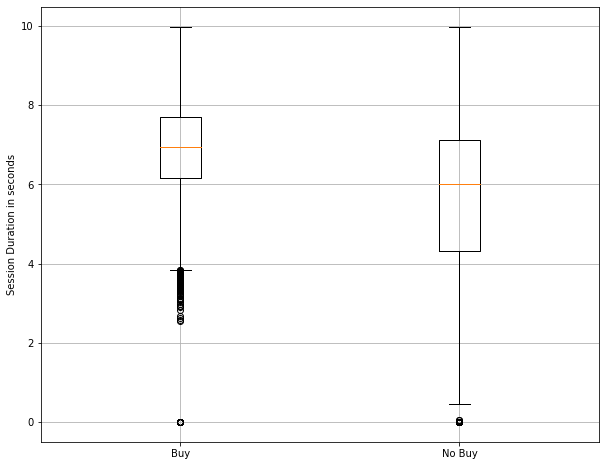

In [41]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
buy = test[test['Buy'] == 1.0]
no_buy = test[test['Buy'] == 0.0]

## Creating side-by-side box plots
plt.boxplot([np.log(buy['Duration'] + 1), np.log(no_buy['Duration'] + 1)], labels = ['Buy', 'No Buy'])
plt.ylabel('Session Duration in seconds')
plt.grid()

plt.show()

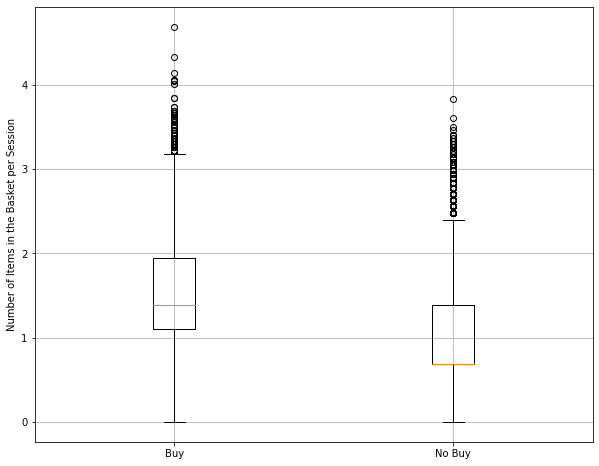

In [49]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
buy = test[test['Buy'] == 1.0]
no_buy = test[test['Buy'] == 0.0]

## Creating side-by-side box plots
plt.boxplot([np.log(buy['Items_in_Basket'] + 1), np.log(no_buy['Items_in_Basket'] + 1)], labels = ['Buy', 'No Buy'])
plt.ylabel('Number of Items in the Basket per Session')
plt.grid()

plt.show()

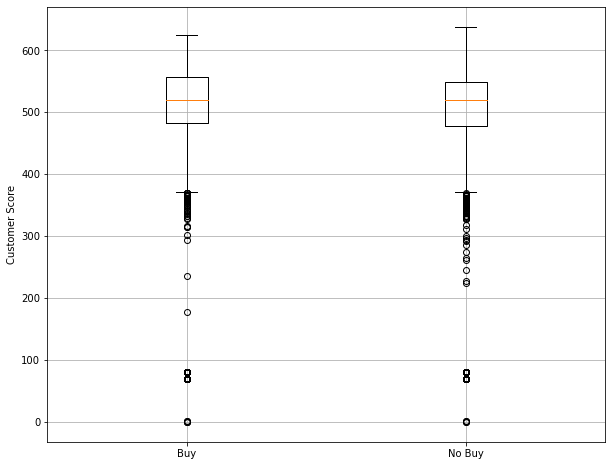

In [23]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
buy = test[test['Buy'] == 1.0]
no_buy = test[test['Buy'] == 0.0]

## Creating side-by-side box plots
plt.boxplot([buy['customer_score'].dropna(), no_buy['customer_score'].dropna()], labels = ['Buy', 'No Buy'])
plt.ylabel('Customer Score')
plt.grid()

plt.show()

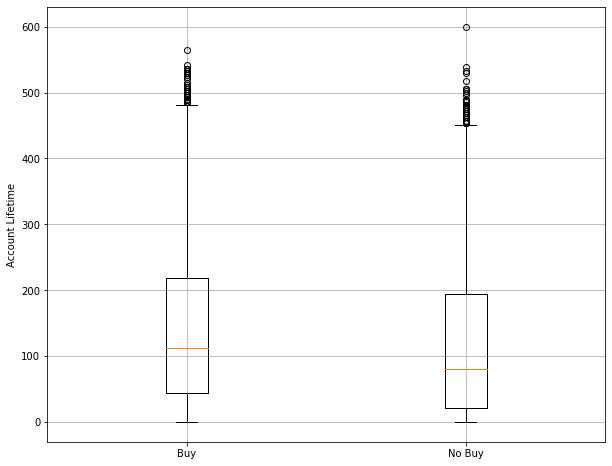

In [24]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
buy = test[test['Buy'] == 1.0]
no_buy = test[test['Buy'] == 0.0]

## Creating side-by-side box plots
plt.boxplot([buy['account_lifetime'].dropna(), no_buy['account_lifetime'].dropna()], labels = ['Buy', 'No Buy'])
plt.ylabel('Account Lifetime')
plt.grid()

plt.show()

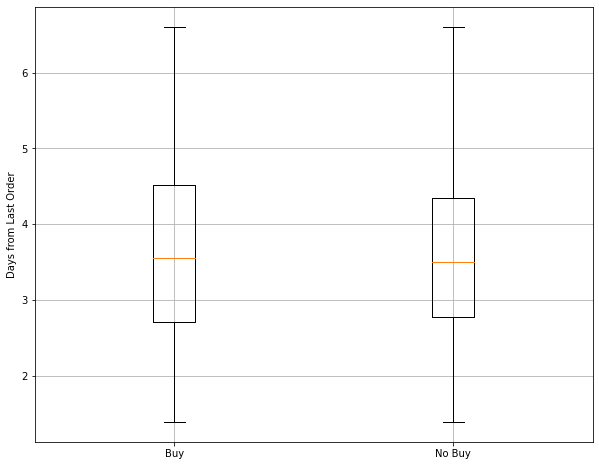

In [26]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
buy = test[test['Buy'] == 1.0]
no_buy = test[test['Buy'] == 0.0]

## Creating side-by-side box plots
plt.boxplot([np.log(buy['days_from_last_order'].dropna() + 1), np.log(no_buy['days_from_last_order'].dropna() + 1)], labels = ['Buy', 'No Buy'])
plt.ylabel('Days from Last Order')
plt.grid()

plt.show()

In [21]:
buy['customer_score'].dropna()

0         70.0
2        475.0
4        503.0
6        575.0
11       546.0
         ...  
49984    407.0
49985    517.0
49986    502.0
49989    504.0
49990    457.0
Name: customer_score, Length: 17152, dtype: float64

In [4]:
len(train['sessionNo'].unique())

50000

In [ ]:
train[train['sessionNo'] == 7]

In [ ]:
len(train['sessionNo'].unique())

In [ ]:
## Reading the test csv file
test = pd.read_csv(file_content_stream_test, sep = '|', na_values = '?')
test.head(10)

## Initial Exploration

In [ ]:
train['order'].value_counts() / train['order'].shape[0]

In [ ]:
train.describe()